In [1]:
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures, FunctionTransformer, OrdinalEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer


/tmp/ipykernel_51411/3031155135.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df = pd.read_csv('data/SBAnational.csv')


/tmp/ipykernel_51411/870068202.py:1: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/SBAnational.csv')


In [3]:
df.dtypes

LoanNr_ChkDgt          int64
Name                  object
City                  object
State                 object
Zip                    int64
Bank                  object
BankState             object
NAICS                  int64
ApprovalDate          object
ApprovalFY            object
Term                   int64
NoEmp                  int64
NewExist             float64
CreateJob              int64
RetainedJob            int64
FranchiseCode          int64
UrbanRural             int64
RevLineCr             object
LowDoc                object
ChgOffDate            object
DisbursementDate      object
DisbursementGross     object
BalanceGross          object
MIS_Status            object
ChgOffPrinGr          object
GrAppv                object
SBA_Appv              object
dtype: object

In [4]:
df.columns

Index(['LoanNr_ChkDgt', 'Name', 'City', 'State', 'Zip', 'Bank', 'BankState',
       'NAICS', 'ApprovalDate', 'ApprovalFY', 'Term', 'NoEmp', 'NewExist',
       'CreateJob', 'RetainedJob', 'FranchiseCode', 'UrbanRural', 'RevLineCr',
       'LowDoc', 'ChgOffDate', 'DisbursementDate', 'DisbursementGross',
       'BalanceGross', 'MIS_Status', 'ChgOffPrinGr', 'GrAppv', 'SBA_Appv'],
      dtype='object')

In [5]:
df.isna().sum()

LoanNr_ChkDgt             0
Name                     14
City                     30
State                    14
Zip                       0
Bank                   1559
BankState              1566
NAICS                     0
ApprovalDate              0
ApprovalFY                0
Term                      0
NoEmp                     0
NewExist                136
CreateJob                 0
RetainedJob               0
FranchiseCode             0
UrbanRural                0
RevLineCr              4528
LowDoc                 2582
ChgOffDate           736465
DisbursementDate       2368
DisbursementGross         0
BalanceGross              0
MIS_Status             1997
ChgOffPrinGr              0
GrAppv                    0
SBA_Appv                  0
dtype: int64

In [6]:
df = df[['Name', 'City', 'State', 'Zip', 'Bank', 'BankState',
       'NAICS', 'ApprovalDate', 'ApprovalFY', 'Term', 'NoEmp', 'NewExist',
       'CreateJob', 'RetainedJob', 'FranchiseCode', 'UrbanRural', 'RevLineCr',
       'LowDoc', 'GrAppv','MIS_Status']]


In [7]:
# Ne prend en compte que les deux premiers chiffres des codes
df['NAICS'] = df['NAICS'].apply(lambda x: int(str(x)[:2])).astype(object)

In [8]:
# converti ApprovalDate
df['ApprovalDate'] = pd.to_datetime(df['ApprovalDate'], format='%d-%b-%y').astype(int)


In [9]:
# Corrige les erreur de ApprovalFY
df['ApprovalFY'].replace('1976A', 1976, inplace=True)

#converti la colonne en int
df['ApprovalFY'] = df['ApprovalFY'].astype(int)

/tmp/ipykernel_51411/164197403.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['ApprovalFY'].replace('1976A', 1976, inplace=True)


In [10]:
# Supprimer le signe dollar 
df['GrAppv'] = df['GrAppv'].apply(lambda x: x.replace('$', ''))

# supprimer la virgule
df['GrAppv'] = df['GrAppv'].apply(lambda x: x.replace(',', ''))

# supprimer le point
df['GrAppv'] = df['GrAppv'].apply(lambda x: x.replace('.', ''))

# Convertir en int
df['GrAppv'] = df['GrAppv'].astype(int)    

In [11]:
from feature_engine.imputation import CategoricalImputer
from sklearn.preprocessing import LabelBinarizer

imputer = CategoricalImputer(imputation_method='frequent', variables=['MIS_Status'])
df = imputer.fit_transform(df)

df.MIS_Status = LabelBinarizer().fit_transform(df.loc[:,['MIS_Status']])
df.MIS_Status = df.MIS_Status.astype('category')

In [12]:
# Corrige la colonne LowDoc
# Remplacement de '[C,S,A,R,1,0]' par NaN
df['LowDoc'] = df['LowDoc'].replace({'[C,S,A,R,1,0]': np.nan})

# Remplacement de 'N' par 0 et 'Y' par 1
df['LowDoc'] = df['LowDoc'].replace({'N': 0, 'Y': 1})

# Remplacement des valeurs différentes de 0 et 1 par NaN
df['LowDoc'] = np.where((df['LowDoc'] != 0) & (df['LowDoc'] != 1), np.nan, df['LowDoc'])
df['LowDoc'] = np.where( (df.GrAppv >= 150000), 0, 1)

df.dropna(subset=['LowDoc'], inplace=True)
df['LowDoc'] = df['LowDoc'].astype(int)






In [13]:
#Corrige la colonne RevLineCr
# Remplacement des valeurs 'N' par 0 et 'Y' par 1
df['RevLineCr'] = df['RevLineCr'].replace({'N': 0, 'Y': 1})

# Remplacement des chaînes '0' par 0 et '1' par 1
df['RevLineCr'] = df['RevLineCr'].replace({'0': 0, '1': 1})

#  Remplacement des valeurs différentes de 0 et 1 par NaN
df['RevLineCr'] = np.where((df['RevLineCr'] != 0) & (df['RevLineCr'] != 1), np.nan, df['RevLineCr'])


In [14]:
#Corrige la colonne NewExist
selected_column = df['NewExist']
replaced_values = selected_column.replace({1.0: 0, 2.0: 1, 0: np.nan})
filled_values = replaced_values.fillna(0)
final_result = filled_values.astype(int)
df['NewExist'] = final_result

In [15]:
# on remplace les na de BankState avec la valeur de State (fortement corrélés)
df.BankState = np.where(df.BankState.isna(), df.State, df.BankState)
# Il en reste 1. City = Pennsville -> New Jersey -> BankState = NJ
df.BankState = np.where(df.BankState.isna(), 'NJ', df.BankState)
# On supprime State
df.drop(columns=['State'], inplace=True)

In [16]:
# Données manquantes
df.isnull().sum()

Name                14
City                30
Zip                  0
Bank              1559
BankState            0
NAICS                0
ApprovalDate         0
ApprovalFY           0
Term                 0
NoEmp                0
NewExist             0
CreateJob            0
RetainedJob          0
FranchiseCode        0
UrbanRural           0
RevLineCr        19854
LowDoc               0
GrAppv               0
MIS_Status           0
dtype: int64

In [17]:
# Les doublons
df.duplicated().sum()

238

In [18]:
df.dtypes


Name               object
City               object
Zip                 int64
Bank               object
BankState          object
NAICS              object
ApprovalDate        int64
ApprovalFY          int64
Term                int64
NoEmp               int64
NewExist            int64
CreateJob           int64
RetainedJob         int64
FranchiseCode       int64
UrbanRural          int64
RevLineCr          object
LowDoc              int64
GrAppv              int64
MIS_Status       category
dtype: object

In [19]:
# Secteurs du NAICS
secteurs = {
    11 : 'Agriculture, forest, fishing',
    21 : 'Mining, oil, Gaz',
    22 : 'Utilities',
    23 : 'Construction',
    31 : 'Manufacturing',
    32 : 'Manufacturing',
    33 : 'Manufacturing',
    42 : 'Wolesale trade',
    44 : 'Retail trade',
    45 : 'Retail trade',
    48 : 'Transportation and warehousing',
    49 : 'Transportation and warehousing',
    51 : 'Information',
    52 : 'Finance and insurance',
    53 : 'Real estate and rental, leasing',
    54 : 'Professional, scientific, technical services',
    55 : 'Management of companies and entreprises',
    56 : 'Administrative and support',
    61 : 'Educational services',
    62 : 'Health care and social',
    71 : 'Arts, entertainment',
    81 : 'Other services',
    92 : 'Public administration'
}

In [20]:
# Colonne qui indique les secteurs du NAICS
df['Sectors'] = df['NAICS'].map(secteurs)


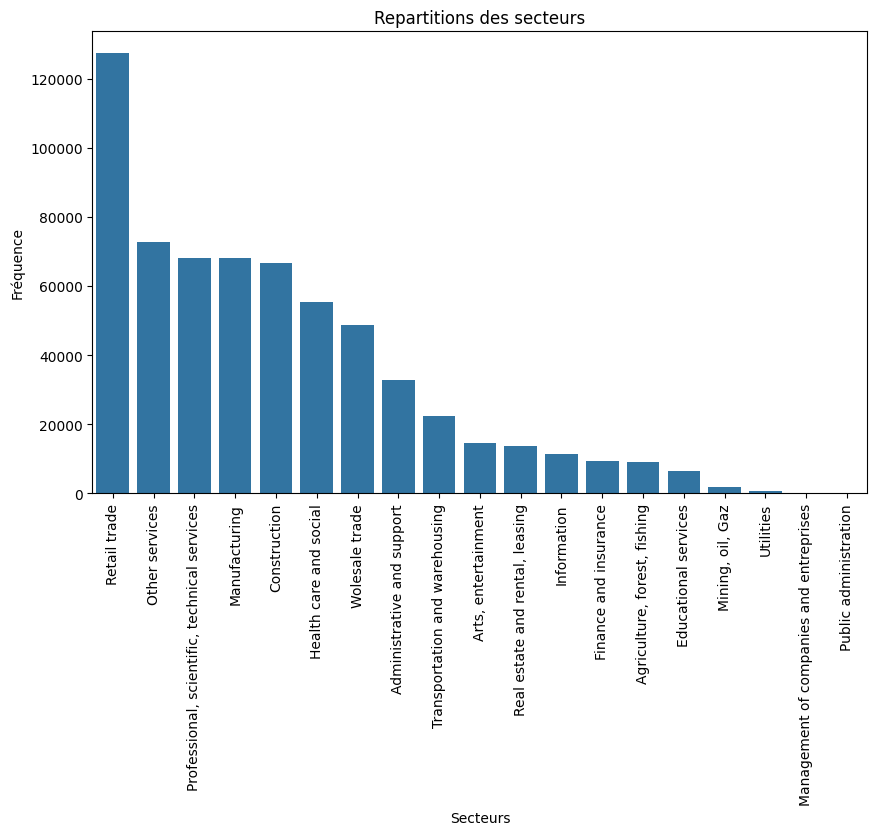

In [21]:
sector_counts = df['Sectors'].value_counts()

# Création du diagramme en barres
plt.figure(figsize=(10, 6))
sns.barplot(x=sector_counts.index, y=sector_counts.values)
plt.title('Repartitions des secteurs')
plt.xlabel('Secteurs')
plt.xticks(rotation = 90)
plt.ylabel('Fréquence')
plt.show()

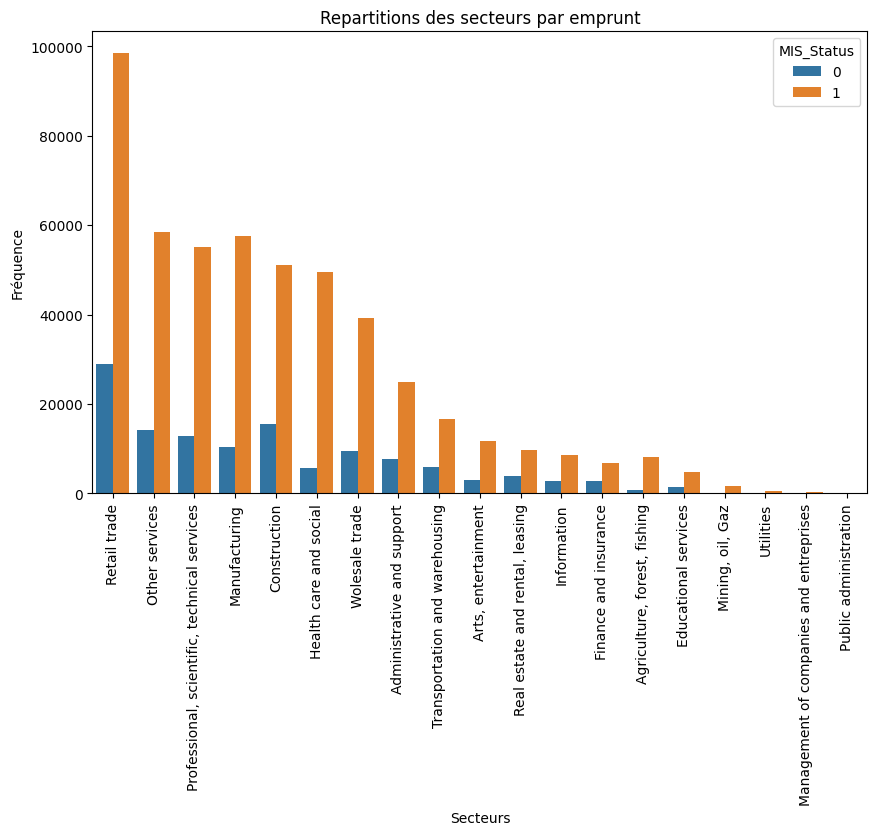

In [22]:
sector_counts = df['Sectors'].value_counts()
order = sector_counts.index

# Création du diagramme en barres
plt.figure(figsize=(10, 6))
sns.countplot(x='Sectors', hue='MIS_Status', data=df, order=order)
plt.title('Repartitions des secteurs par emprunt')
plt.xlabel('Secteurs')
plt.xticks(rotation = 90)
plt.ylabel('Fréquence')
plt.show()

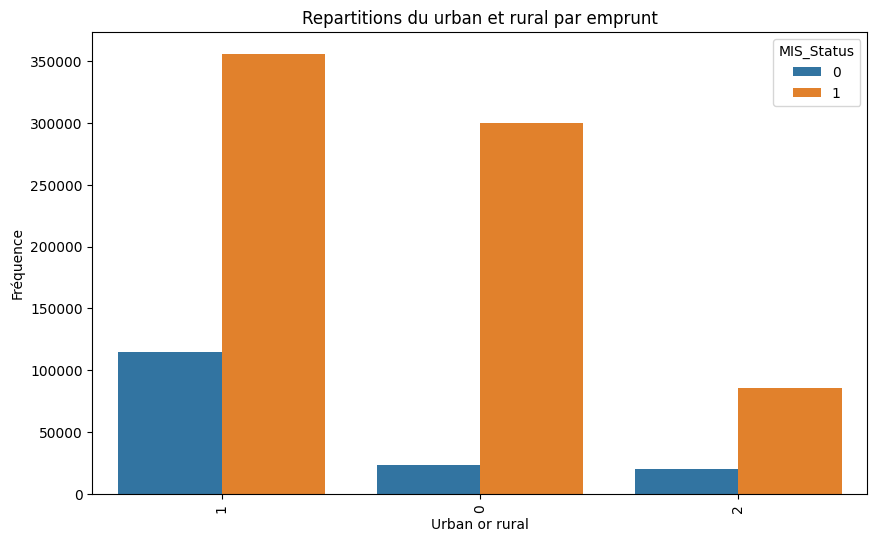

In [23]:
urban_counts = df['UrbanRural'].value_counts()
order = urban_counts.index

# Création du diagramme en barres
plt.figure(figsize=(10, 6))
sns.countplot(x='UrbanRural', hue='MIS_Status', data=df, order=order)
plt.title('Repartitions du urban et rural par emprunt')
plt.xlabel('Urban or rural')
plt.xticks(rotation = 90)
plt.ylabel('Fréquence')
plt.show()

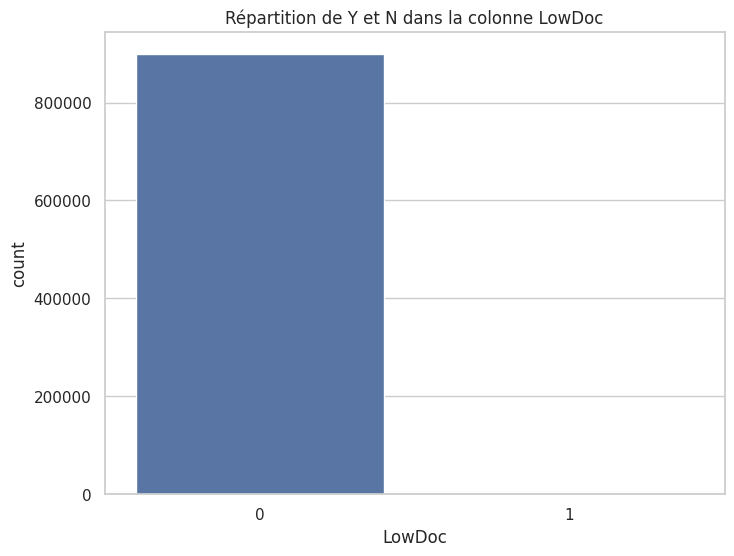

LowDoc
0    898659
1       505
Name: count, dtype: int64

In [24]:

sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))

# Utilise la fonction countplot de Seaborn
sns.countplot(x=df['LowDoc'], data=df)

plt.title('Répartition de Y et N dans la colonne LowDoc')
plt.show()
df['LowDoc'].value_counts()

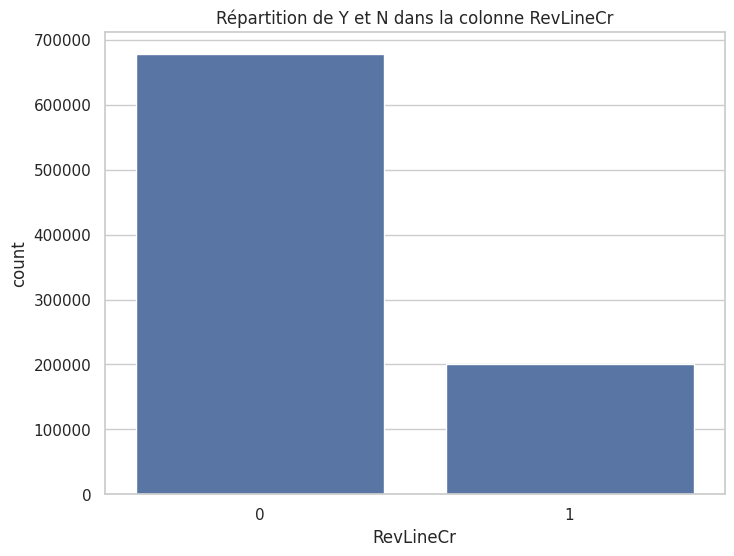

[0 1 nan]


In [25]:

sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))

# Utilise la fonction countplot de Seaborn
sns.countplot(x='RevLineCr', data=df)

plt.title('Répartition de Y et N dans la colonne RevLineCr')
plt.show()
print(df['RevLineCr'].unique())

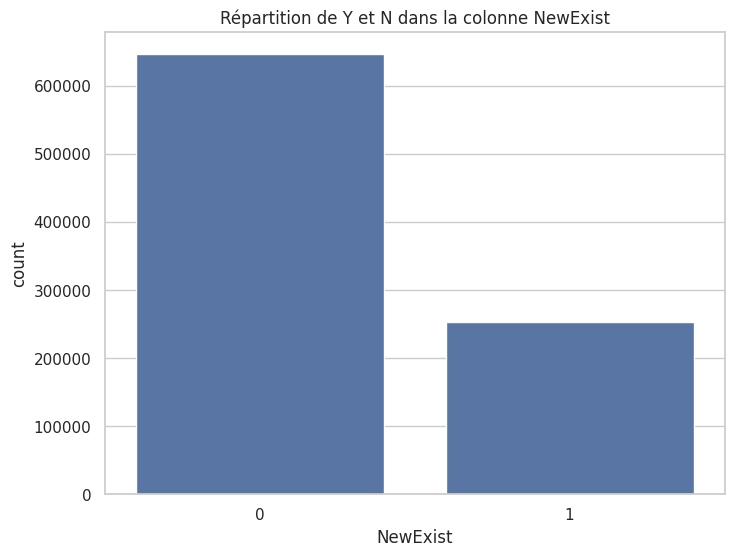

In [26]:

sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))

# Utilise la fonction countplot de Seaborn
sns.countplot(x='NewExist', data=df)

plt.title('Répartition de Y et N dans la colonne NewExist')
plt.show()

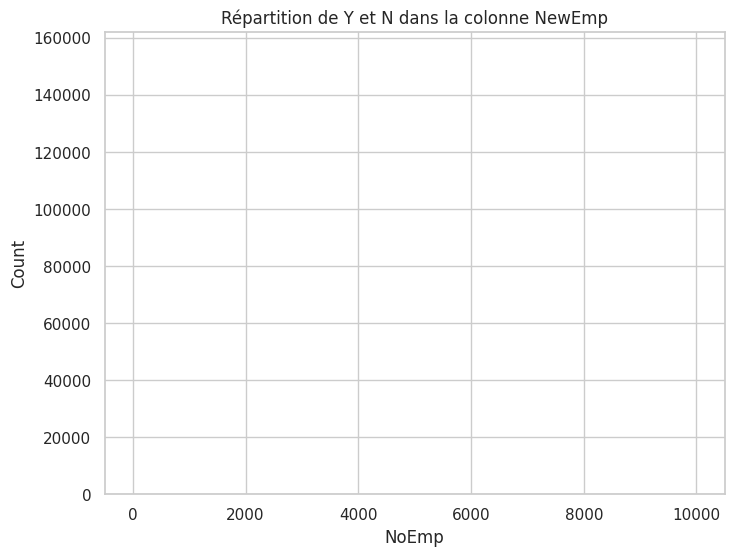

In [27]:
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))

# Utilise la fonction countplot de Seaborn
sns.histplot(x=df['NoEmp'], data=df)

plt.title('Répartition de Y et N dans la colonne NewEmp')
plt.show()

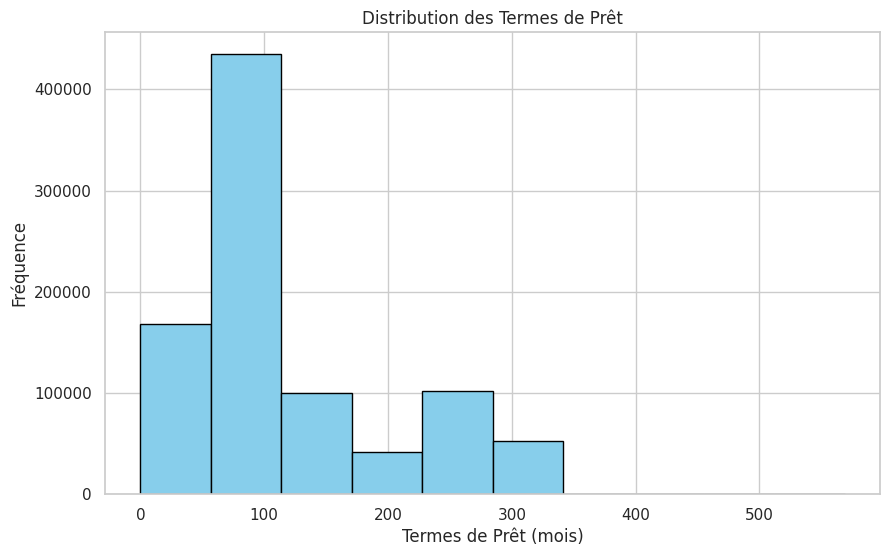

In [28]:
df['Term'] = pd.to_numeric(df['Term'], errors='coerce')

# Créer un histogramme
plt.figure(figsize=(10, 6))
plt.hist(df['Term'].dropna(), bins=10, color='skyblue', edgecolor='black')
plt.title('Distribution des Termes de Prêt')
plt.xlabel('Termes de Prêt (mois)')
plt.ylabel('Fréquence')
plt.show()

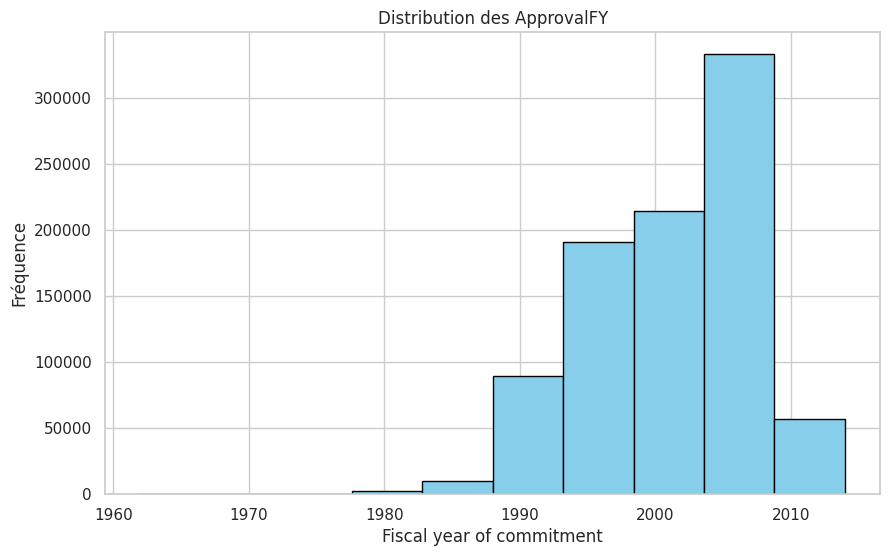

In [29]:
# Créer un histogramme
plt.figure(figsize=(10, 6))
plt.hist(df['ApprovalFY'].dropna(), color='skyblue', edgecolor='black')
plt.title('Distribution des ApprovalFY')
plt.xlabel('Fiscal year of commitment')
plt.ylabel('Fréquence')
plt.show()

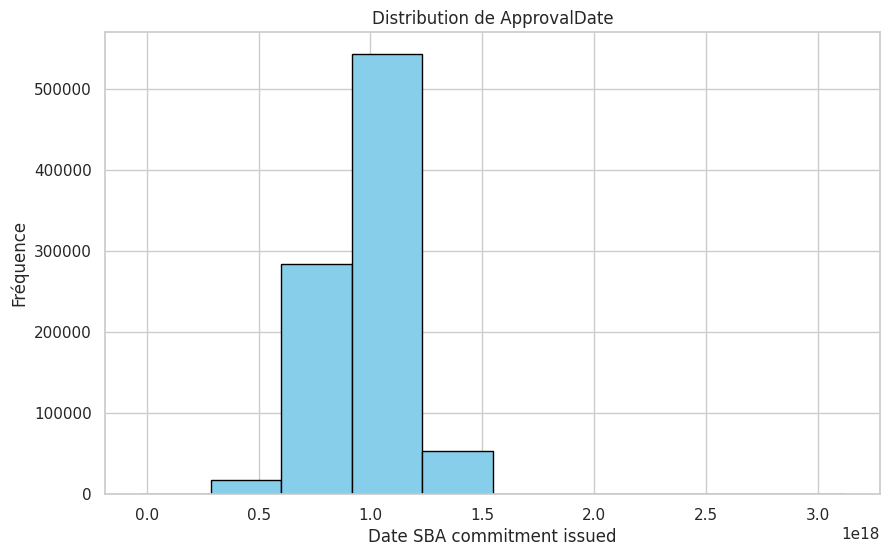

In [30]:
# Créer un histogramme
plt.figure(figsize=(10, 6))
plt.hist(df['ApprovalDate'].dropna(), bins=10, color='skyblue', edgecolor='black')
plt.title('Distribution de ApprovalDate')
plt.xlabel('Date SBA commitment issued')
plt.ylabel('Fréquence')
plt.show()

In [31]:
df.columns

Index(['Name', 'City', 'Zip', 'Bank', 'BankState', 'NAICS', 'ApprovalDate',
       'ApprovalFY', 'Term', 'NoEmp', 'NewExist', 'CreateJob', 'RetainedJob',
       'FranchiseCode', 'UrbanRural', 'RevLineCr', 'LowDoc', 'GrAppv',
       'MIS_Status', 'Sectors'],
      dtype='object')

In [32]:
df.dtypes


Name               object
City               object
Zip                 int64
Bank               object
BankState          object
NAICS              object
ApprovalDate        int64
ApprovalFY          int64
Term                int64
NoEmp               int64
NewExist            int64
CreateJob           int64
RetainedJob         int64
FranchiseCode       int64
UrbanRural          int64
RevLineCr          object
LowDoc              int64
GrAppv              int64
MIS_Status       category
Sectors            object
dtype: object

In [33]:
import xgboost as xgb
# Supprimer les lignes contenant des valeurs manquantes
df_clean = df.dropna()

# Séparer les variables indépendantes et la variable dépendante
X = df_clean.drop(['MIS_Status'], axis=1)
y = df_clean['MIS_Status']

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Définir les paramètres du modèle XGBoost
params = {
    'tree_method': 'hist',  # Utiliser l'algorithme histogramme
    'device': 'cuda'  # Utiliser le GPU pour l'entraînement
}

# Créer le modèle XGBoost avec les paramètres
model_xgb = xgb.XGBClassifier(**params, random_state=42, n_jobs=-1)

# Définir les transformations à appliquer aux variables numériques et catégorielles
transformers = [
    ('num', StandardScaler(), ['ApprovalFY', 'Term', 'NewExist', 'GrAppv']),
    ('cat', OneHotEncoder(drop='if_binary'), ['NAICS', 'NoEmp', 'LowDoc', 'CreateJob', 'RetainedJob', 'FranchiseCode', 'UrbanRural', 'RevLineCr', 'ApprovalDate'])
]

# Créer le pipeline de transformation et d'entraînement
pipeline_xgb = make_pipeline(
    ColumnTransformer(transformers=transformers),
    model_xgb
)

# Entraîner le modèle
pipeline_xgb.fit(X_train, y_train)



Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['ApprovalFY', 'Term',
                                                   'NewExist', 'GrAppv']),
                                                 ('cat',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['NAICS', 'NoEmp', 'LowDoc',
                                                   'CreateJob', 'RetainedJob',
                                                   'FranchiseCode',
                                                   'UrbanRural', 'RevLineCr',
                                                   'ApprovalDate'])])),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, ca...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=-1,
                               num_parallel_tree=None, random_state=42, ...))])

Matrice de confusion:

Accuracy:
0.9391687800633772


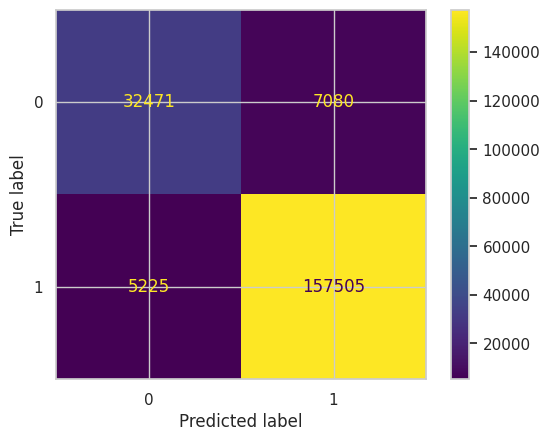

In [34]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, ConfusionMatrixDisplay
from xgboost import XGBClassifier

# Créer le transformateur pour les colonnes catégorielles
categorical_features = ['NAICS', 'NoEmp', 'CreateJob', 'RetainedJob', 'FranchiseCode', 'UrbanRural', 'RevLineCr', 'ApprovalDate']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Créer le transformateur pour les colonnes numériques
numerical_features =['ApprovalFY', 'Term', 'NewExist', 'LowDoc', 'GrAppv']
numerical_transformer = SimpleImputer(strategy='mean')



# Créer le ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
        ])

# Créer le pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', XGBClassifier())])

# Entraîner le modèle
pipeline.fit(X_train, y_train)

# Prédire les classes pour les données de test
y_pred = pipeline.predict(X_test)

# Calculer les métriques
print("Matrice de confusion:")
cf_matrix = confusion_matrix(y_test, y_pred)

print("\nAccuracy:")
print(accuracy_score(y_test, y_pred))

cf_matrixD = ConfusionMatrixDisplay(cf_matrix)
cf_matrixD.plot()



In [35]:
# Importer les métriques de performance
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Rapport de classification
class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

# Score de précision
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)




Confusion Matrix:
[[ 32471   7080]
 [  5225 157505]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.82      0.84     39551
           1       0.96      0.97      0.96    162730

    accuracy                           0.94    202281
   macro avg       0.91      0.89      0.90    202281
weighted avg       0.94      0.94      0.94    202281

Accuracy: 0.9391687800633772


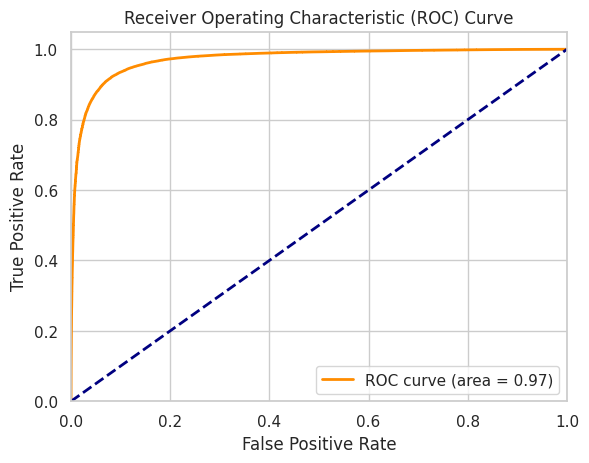

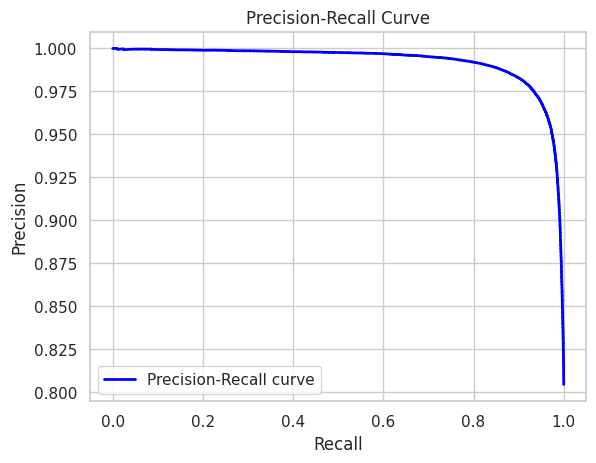

In [36]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, auc

# Calculer les probabilités prédites pour la classe positive
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

# Courbe ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Courbe de précision-rappel
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)

plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

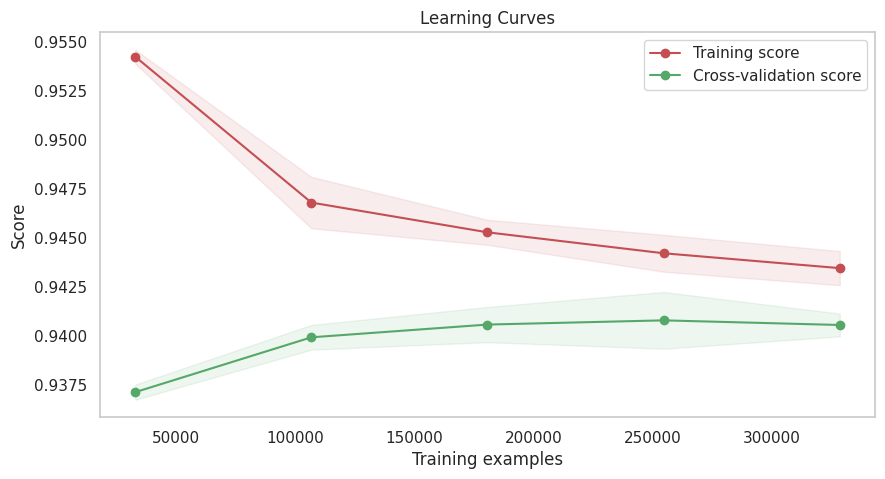

In [37]:
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, ConfusionMatrixDisplay


train_sizes, train_scores, test_scores, fit_times, _ = \
    learning_curve(pipeline, X_train, y_train, cv=5, n_jobs=-1,
                   train_sizes=np.linspace(.1, 1.0, 5), return_times=True)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
fit_times_mean = np.mean(fit_times, axis=1)
fit_times_std = np.std(fit_times, axis=1)

plt.figure(figsize=(10, 5))
plt.title("Learning Curves")
plt.xlabel("Training examples")
plt.ylabel("Score")

plt.grid()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
plt.legend(loc="best")

plt.show()


In [38]:
#Obtenir les importances des caractéristiques du modèle XGBoost
feature_importances = pipeline.named_steps['classifier'].feature_importances_

#Obtenir les noms des caractéristiques transformées
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

#Créer un DataFrame pour visualiser les importances
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

#Afficher les importances des caractéristiques
importance_df.head(15)

,Feature,Importance
1,num__Term,0.147344
925,cat__FranchiseCode_1,0.077754
0,num__ApprovalFY,0.049620
2333,cat__UrbanRural_1,0.025624
2335,cat__RevLineCr_0,0.020829
24,cat__NAICS_62,0.015712
643,cat__RetainedJob_0,0.015318
924,cat__FranchiseCode_0,0.014388
2334,cat__UrbanRural_2,0.013504
4,num__GrAppv,0.011111


In [39]:
df.isna().sum()

Name                 14
City                 30
Zip                   0
Bank               1559
BankState             0
NAICS                 0
ApprovalDate          0
ApprovalFY            0
Term                  0
NoEmp                 0
NewExist              0
CreateJob             0
RetainedJob           0
FranchiseCode         0
UrbanRural            0
RevLineCr         19854
LowDoc                0
GrAppv                0
MIS_Status            0
Sectors          269548
dtype: int64

In [40]:
from feature_engine.imputation import RandomSampleImputer

imputer = RandomSampleImputer()

result = imputer.fit_transform(df.loc[:,['RevLineCr']])
df.RevLineCr = result['RevLineCr']


In [41]:
df.isna().sum()

Name                 14
City                 30
Zip                   0
Bank               1559
BankState             0
NAICS                 0
ApprovalDate          0
ApprovalFY            0
Term                  0
NoEmp                 0
NewExist              0
CreateJob             0
RetainedJob           0
FranchiseCode         0
UrbanRural            0
RevLineCr             0
LowDoc                0
GrAppv                0
MIS_Status            0
Sectors          269548
dtype: int64

In [42]:
df.FranchiseCode.unique()

array([    1,     0, 15100, ...,  2899, 18701, 15930])

In [43]:
df['FranchiseCode'].astype(int)


0         1
1         1
2         1
3         1
4         1
         ..
899159    1
899160    1
899161    1
899162    1
899163    1
Name: FranchiseCode, Length: 899164, dtype: int64

In [44]:
condition_franchise = (df['FranchiseCode'] > 1)
df.loc[condition_franchise, 'FranchiseCode'] = 1
df.loc[~condition_franchise, 'FranchiseCode'] = 0


